In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.svm import LinearSVC

In [2]:
#importing data set from Web Scraping.ipynb file

In [3]:
data_set = pd.read_csv("nba_players_stats.csv")

In [4]:
#splitting data set to test for 2020 award winners and dropping columns that are not needed

In [5]:
players_for_testing_prediction = data_set[data_set['Season'] == 2020]
working_set = data_set[data_set['Season'] < 2020]

In [6]:
working_set = working_set.drop(columns = ['Player', 'Pos', 'Tm', 'Season', 'Team'])

In [7]:
#creating correlation matrix

In [8]:
corr = working_set.corr()

In [9]:
import matplotlib.pyplot as plt

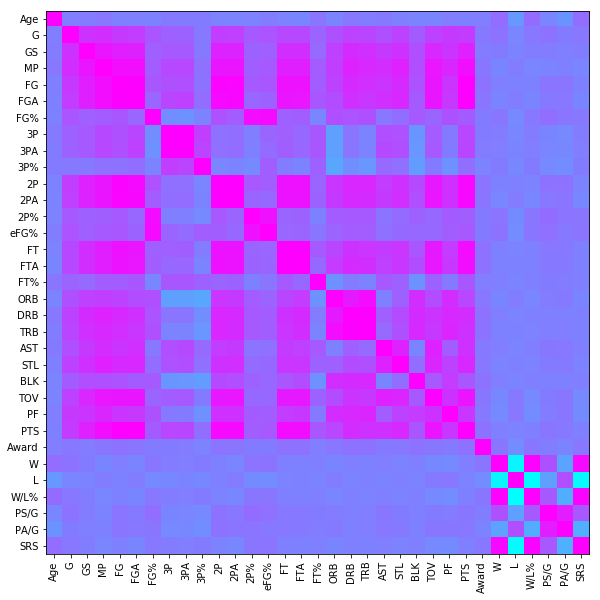

In [10]:
#fig, ax = plt.subplots(figsize=(13,13))
#plt.matshow(corr)
names = corr.axes[0].tolist()
plt.rcParams["figure.figsize"] = (10,10)
plt.xticks(np.arange(len(names)),names,rotation=90)
plt.yticks(np.arange(len(names)),names)
#ax.set_xticklabels(corr.axes[0].tolist())
#ax.set_yticklabels(corr.axes[0].tolist())
plt.imshow(corr, cmap='cool',interpolation="nearest")

In [11]:
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Award,W,L,W/L%,PS/G,PA/G,SRS
Age,1,0.026,0.043,0.074,0.009,0.0095,0.0048,0.06,0.049,0.051,-0.0076,-0.0082,-0.0018,0.033,-0.003,-0.024,0.095,-0.021,0.063,0.038,0.059,0.0074,-0.012,-0.016,0.03,0.012,0.025,0.16,-0.17,0.17,-0.037,-0.14,0.16
G,0.026,1,0.61,0.65,0.55,0.53,0.34,0.25,0.24,0.063,0.52,0.5,0.31,0.35,0.44,0.43,0.23,0.38,0.48,0.47,0.39,0.48,0.29,0.48,0.55,0.54,0.067,0.11,-0.037,0.077,0.11,0.053,0.078
GS,0.043,0.61,1,0.84,0.76,0.74,0.27,0.3,0.3,0.061,0.73,0.72,0.24,0.26,0.65,0.65,0.19,0.49,0.66,0.64,0.55,0.62,0.39,0.7,0.59,0.75,0.041,0.047,-0.013,0.031,0.043,0.022,0.031
MP,0.074,0.65,0.84,1,0.89,0.9,0.28,0.43,0.44,0.13,0.84,0.84,0.27,0.31,0.77,0.77,0.29,0.51,0.73,0.69,0.66,0.75,0.39,0.82,0.7,0.89,0.091,-0.028,0.034,-0.032,-0.0099,0.011,-0.032
FG,0.009,0.55,0.76,0.89,1,0.98,0.33,0.38,0.39,0.11,0.96,0.96,0.3,0.32,0.86,0.85,0.29,0.48,0.67,0.64,0.6,0.67,0.36,0.83,0.6,0.99,0.11,0.016,0.0029,0.0066,0.1,0.097,0.0075
FGA,0.0095,0.53,0.74,0.9,0.98,1,0.21,0.47,0.49,0.15,0.92,0.94,0.2,0.23,0.85,0.83,0.32,0.41,0.63,0.58,0.63,0.7,0.29,0.84,0.56,0.98,0.098,-0.019,0.032,-0.026,0.058,0.075,-0.026
FG%,0.0048,0.34,0.27,0.28,0.33,0.21,1,-0.085,-0.13,-0.015,0.37,0.28,0.91,0.92,0.25,0.28,-0.036,0.39,0.35,0.38,0.075,0.15,0.31,0.22,0.37,0.29,0.049,0.086,-0.06,0.075,0.15,0.096,0.081
3P,0.06,0.25,0.3,0.43,0.38,0.47,-0.085,1,0.98,0.51,0.13,0.15,0.017,0.22,0.26,0.2,0.33,-0.23,0.093,-0.013,0.4,0.37,-0.15,0.29,0.054,0.45,0.046,0.044,-0.041,0.043,-0.029,-0.059,0.044
3PA,0.049,0.24,0.3,0.44,0.39,0.49,-0.13,0.98,1,0.47,0.14,0.16,0.012,0.17,0.27,0.21,0.33,-0.24,0.093,-0.016,0.42,0.4,-0.16,0.31,0.05,0.46,0.043,0.025,-0.023,0.024,-0.036,-0.053,0.025
3P%,0.051,0.063,0.061,0.13,0.11,0.15,-0.015,0.51,0.47,1,-0.034,-0.02,-0.056,0.28,0.034,-0.012,0.24,-0.28,-0.093,-0.16,0.18,0.13,-0.21,0.048,-0.11,0.14,-0.0035,0.047,-0.047,0.048,-0.058,-0.092,0.051


In [12]:
#creating data set model by filling na values with 0

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
working_set_model = working_set.fillna(0)
players_for_testing_prediction = players_for_testing_prediction.fillna(0)

In [15]:
working_set_model.columns

Index(['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Award', 'W', 'L', 'W/L%', 'PS/G',
       'PA/G', 'SRS'],
      dtype='object')

In [16]:
#dropping highly correlated columns, threshold of 0.95

In [17]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    dataset.drop(colname, axis=1,inplace=True) # deleting the column from the dataset

In [18]:
correlation(working_set_model, 0.95)

In [19]:
#splitting model into team stats and player stats so we can compare later

In [20]:
working_set_model.columns

Index(['Age', 'G', 'GS', 'MP', 'FG', 'FG%', '3P', '3P%', '2P%', 'eFG%', 'FT',
       'FT%', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'Award', 'W',
       'L', 'PS/G', 'PA/G', 'SRS'],
      dtype='object')

In [21]:
model_players = working_set_model[working_set_model.columns[0:20]]

In [22]:
model_players.columns

Index(['Age', 'G', 'GS', 'MP', 'FG', 'FG%', '3P', '3P%', '2P%', 'eFG%', 'FT',
       'FT%', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'Award'],
      dtype='object')

In [64]:
X = model_players.drop('Award', axis=1)
y = model_players['Award']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [25]:
#generating the model

In [67]:
from sklearn.svm import SVC

In [68]:
svclassifier = SVC(kernel='linear')

In [69]:
svclassifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [70]:
y_pred = svclassifier.predict(X_test)

In [30]:
#confusion matrix to measure accuracy of model

In [71]:
from sklearn.metrics import classification_report, confusion_matrix

In [72]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[2783    0    0    0]
 [   6    0    0    0]
 [   2    0    0    0]
 [   6    0    0    0]]
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      2783
          1       0.00      0.00      0.00         6
          2       0.00      0.00      0.00         2
          3       0.00      0.00      0.00         6

avg / total       0.99      0.99      0.99      2797



/usr/lib/python3/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [73]:
svclassifier.score(X_test, y_test)

0.99499463711119052

In [74]:
#non award winners overrepresented so running a penalized-svm to correct for class imbalance

In [75]:
svclassifier_penalized = SVC(kernel='linear', class_weight='balanced', probability=True)

In [76]:
svclassifier_penalized.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [77]:
y_penal_pred = svclassifier_penalized.predict(X_test)

In [78]:
print(confusion_matrix(y_test,y_penal_pred))
print(classification_report(y_test,y_penal_pred))

[[2596   24  114   49]
 [   2    4    0    0]
 [   0    0    2    0]
 [   3    0    0    3]]
             precision    recall  f1-score   support

          0       1.00      0.93      0.96      2783
          1       0.14      0.67      0.24         6
          2       0.02      1.00      0.03         2
          3       0.06      0.50      0.10         6

avg / total       0.99      0.93      0.96      2797



In [79]:
svclassifier_penalized.score(X_test, y_test)

0.93135502323918484

In [40]:
#~90% accuarcy re-doing the test with the team data

In [41]:
X_team = working_set_model.drop('Award', axis=1)
y_team = working_set_model['Award']

In [42]:
X_train_team, X_test_team, y_train_team, y_test_team = train_test_split(X, y, test_size = 0.2)

In [43]:
svclassifier_team = SVC(kernel='linear')

In [44]:
svclassifier_team.fit(X_train_team, y_train_team)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [45]:
y_pred_team = svclassifier_team.predict(X_test_team)

In [46]:
print(confusion_matrix(y_test_team,y_pred_team))
print(classification_report(y_test_team,y_pred_team))

[[2771    3    0    0]
 [   2    8    0    0]
 [   6    0    0    0]
 [   7    0    0    0]]
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      2774
          1       0.73      0.80      0.76        10
          2       0.00      0.00      0.00         6
          3       0.00      0.00      0.00         7

avg / total       0.99      0.99      0.99      2797



/usr/lib/python3/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
svclassifier_team.score(X_test_team, y_test_team)

0.99356453342867357

In [48]:
#with penalized-svm

In [49]:
svclassifier_team_penalized = SVC(kernel='linear', class_weight='balanced', probability=True)

In [50]:
svclassifier_team_penalized.fit(X_train_team, y_train_team)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
y_penal_team_pred = svclassifier_team_penalized.predict(X_test_team)

In [52]:
print(confusion_matrix(y_test_team,y_penal_team_pred))
print(classification_report(y_test_team,y_penal_team_pred))

[[2679   15   40   40]
 [   1    8    1    0]
 [   1    0    5    0]
 [   1    0    0    6]]
             precision    recall  f1-score   support

          0       1.00      0.97      0.98      2774
          1       0.35      0.80      0.48        10
          2       0.11      0.83      0.19         6
          3       0.13      0.86      0.23         7

avg / total       0.99      0.96      0.98      2797



In [53]:
svclassifier_team_penalized.score(X_test_team, y_test_team)

0.96460493385770474

In [54]:
#accuracy improved but not by much ~1-2% points

In [58]:
X_new = players_for_testing_prediction[['Age', 'G', 'GS', 'MP', 'FG', 'FG%', '3P', '3P%', '2P%', 'eFG%', 'FT',
       'FT%', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'W','L', 'PS/G', 'PA/G', 'SRS']]

In [59]:
y_new = svclassifier_team_penalized.predict(X_new)

In [62]:
players_for_testing_prediction['model_prediction'] = y_new

In [63]:
players_for_testing_prediction[players_for_testing_prediction['model_prediction'] != 0]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,Season,Award,Team,W,L,W/L%,PS/G,PA/G,SRS,model_prediction
13998,Dennis Schröder,PG,26,OKC,65,2,30.8,7.0,14.8,0.469,...,2020,0,Oklahoma City Thunder,44,28,0.611,110.4,108.4,2.33,3
14123,James Harden,SG,30,HOU,68,68,36.5,9.9,22.3,0.444,...,2020,0,Houston Rockets,44,28,0.611,117.8,114.8,3.13,1
14133,Giannis Antetokounmpo,PF,25,MIL,63,63,30.4,10.9,19.7,0.553,...,2020,0,Milwaukee Bucks,56,17,0.767,118.7,108.6,9.41,1
14159,LeBron James,PG,35,LAL,67,67,34.6,9.6,19.4,0.493,...,2020,0,Los Angeles Lakers,52,19,0.732,113.4,107.6,6.28,1
14323,Montrezl Harrell,C,26,LAC,63,2,27.8,7.5,12.9,0.580,...,2020,0,Los Angeles Clippers,49,23,0.681,116.3,109.9,6.66,3
